In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!git clone https://github.com/sc4789/mipsdata.git

Cloning into 'mipsdata'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 302 (delta 298), reused 302 (delta 298), pack-reused 0
Receiving objects: 100% (302/302), 24.79 MiB | 36.95 MiB/s, done.
Resolving deltas: 100% (298/298), done.


## Data Preprocessing

In [4]:
import os
import SimpleITK as sitk

def decompress_nifti(input_file, output_file):
    """
    Decompress a .nii.gz file using SimpleITK.
    
    Args:
        input_file (string): Path to the input .nii.gz file.
        output_file (string): Path to the output .nii file.
    """
    try:
        sitk_img = sitk.ReadImage(input_file)  # load with SimpleITK
        sitk.WriteImage(sitk_img, output_file)  # save as uncompressed .nii
        print(f"Decompressed {input_file} to {output_file}.")
    except Exception as e:
        print(f"Error processing {input_file}: {e}")

# Directory containing the .nii.gz files
folder_path = 'mipsdata'

# Iterate through each .nii.gz file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.nii.gz'):
        input_file = os.path.join(folder_path, filename)
        output_file = os.path.join(folder_path, filename.replace('.nii.gz', '.nii'))
        decompress_nifti(input_file, output_file)


Decompressed mipsdata/ATM_048_0000_mips.nii.gz to mipsdata/ATM_048_0000_mips.nii.
Decompressed mipsdata/ATM_005_0000_mips.nii.gz to mipsdata/ATM_005_0000_mips.nii.
Decompressed mipsdata/ATM_264_0000_mips.nii.gz to mipsdata/ATM_264_0000_mips.nii.
Decompressed mipsdata/ATM_242_0000_mips.nii.gz to mipsdata/ATM_242_0000_mips.nii.
Decompressed mipsdata/ATM_075_0000_mips.nii.gz to mipsdata/ATM_075_0000_mips.nii.
Decompressed mipsdata/ATM_630_0000_mips.nii.gz to mipsdata/ATM_630_0000_mips.nii.
Decompressed mipsdata/ATM_081_0000_mips.nii.gz to mipsdata/ATM_081_0000_mips.nii.
Decompressed mipsdata/ATM_082_0000_mips.nii.gz to mipsdata/ATM_082_0000_mips.nii.
Decompressed mipsdata/ATM_171_0000_mips.nii.gz to mipsdata/ATM_171_0000_mips.nii.
Decompressed mipsdata/ATM_139_0000_mips.nii.gz to mipsdata/ATM_139_0000_mips.nii.
Decompressed mipsdata/ATM_682_0000_mips.nii.gz to mipsdata/ATM_682_0000_mips.nii.
Decompressed mipsdata/ATM_696_0000_mips.nii.gz to mipsdata/ATM_696_0000_mips.nii.
Decompressed mip

In [5]:
import os
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader

class NiftiDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the NIfTI files.
        """
        self.root_dir = root_dir
        self.file_list = [f for f in os.listdir(root_dir) if f.endswith('.nii')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        nii_file = os.path.join(self.root_dir, self.file_list[idx])
        sitk_img = sitk.ReadImage(nii_file)
        img_data = sitk.GetArrayFromImage(sitk_img)
        
        # Normalize the image data
        img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())
        img_data[img_data > 0.5] = 1
        target_data = img_data.copy()
        
        return torch.tensor(img_data, dtype=torch.float32), torch.tensor(img_data, dtype=torch.float32)


# Directory containing the .nii files
root_dir = 'mipsdata'

# Create a NiftiDataset instance
dataset = NiftiDataset(root_dir)

# Create a DataLoader
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Test the DataLoader
for i, (data, target) in enumerate(dataloader):
    print(f'Batch {i+1}, Data Shape: {data.shape}, Target Shape: {target.shape}')


Batch 1, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 2, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 3, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 4, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 5, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 6, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 7, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 8, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 9, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 10, Data Shape: torch.Size([4, 256, 256, 3]), Target Shape: torch.Size([4, 256, 256, 3])
Batch 11, Data Shape: torch.Size([4, 256, 256, 3]), Target 

### Visualizing the samples

Batch 1, Shape: torch.Size([4, 256, 256, 3])


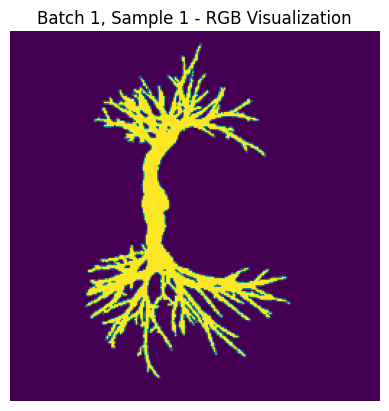

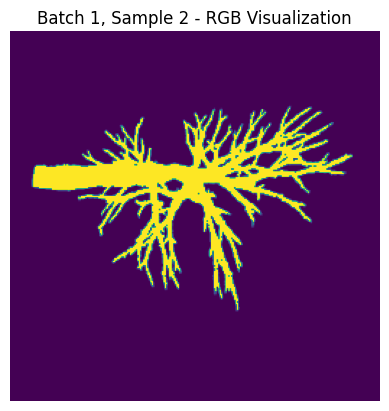

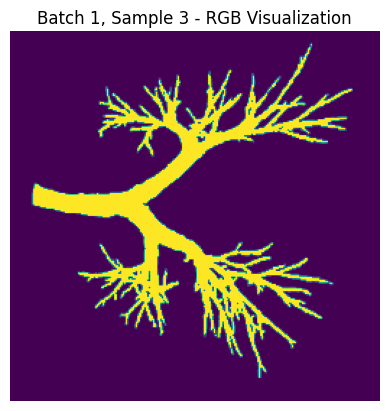

In [6]:
import matplotlib.pyplot as plt

# Test the DataLoader and visualize the first image from the first batch
for i, (data, target) in enumerate(dataloader):
    print(f'Batch {i+1}, Shape: {data.shape}')
    
    # Visualize the first sample in the first batch
    sample = data[0]  # Get the first sample
   
    # Visualize as RGB
    plt.imshow(sample[:, :, 0])
    plt.axis('off')
    plt.title(f'Batch {i+1}, Sample 1 - RGB Visualization')
    plt.show()
    
    plt.imshow(sample[:, :, 1])
    plt.axis('off')
    plt.title(f'Batch {i+1}, Sample 2 - RGB Visualization')
    plt.show()
    
    plt.imshow(sample[:, :, 2])
    plt.axis('off')
    plt.title(f'Batch {i+1}, Sample 3 - RGB Visualization')
    plt.show()

    # Break the loop after visualizing the first batch
    break


Batch 1, Shape: torch.Size([4, 256, 256, 3])


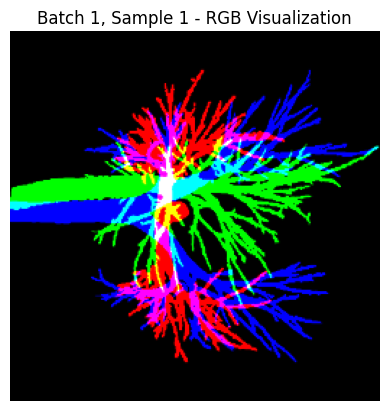

3631


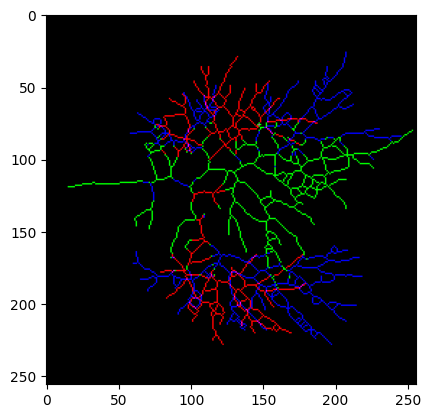

In [7]:
from skimage.morphology import skeletonize

# Test the DataLoader and visualize the first image from the first batch
for i, (data, target) in enumerate(dataloader):
    print(f'Batch {i+1}, Shape: {data.shape}')
    
    # Visualize the first sample in the first batch
    sample = data[0]  # Get the first sample
   
    # Visualize as RGB
    plt.imshow(sample)
    plt.axis('off')
    plt.title(f'Batch {i+1}, Sample 1 - RGB Visualization')
    plt.show()
    
    skel = skeletonize(sample.cpu().numpy() )
#     ((pred_skel> 0) * (skel > 0)).sum() / (skel.sum())
    plt.imshow(skel)
    print((skel > 0).sum())
   
    # Break the loop after visualizing the first batch
    break


from skimage.morphology import skeletonize


## Defining the Model Architecture - AttentionUNet

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        
        # Define a convolutional block consisting of two convolutional layers

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through the convolutional block
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        # Define an upsampling block consisting of upsampling and a convolutional layer
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through the upsampling block
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()
        # Define an attention block with learnable parameters
        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

#     def forward(self, gate, skip_connection):
    def forward(self, gate):

        
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        psi = self.relu(g1)
        psi = self.psi(psi)
        out = gate * psi 
        return out
    

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # Define the output convolutional layer with Sigmoid activation

        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Forward pass through the output convolutional layer

        return self.conv_sigmoid(x)
    
    
class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=3):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(2)
        # Define the encoder part of the network with convolutional blocks and max pooling

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        # Define the decoder part of the network with upsampling blocks and attention blocks
        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)

        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)
        # Define the output layer
        self.outputL = OutConv(64, output_ch)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        
        # Permute input tensor to match expected input format

        x = x.permute(0, 3, 1, 2)

        # Encoder
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)
        
        # Decoder with attention
        d5 = self.Up5(e5)
        s4 = self.Att5(gate=d5)
        d5 = torch.cat((s4, d5), dim=1)
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3)

        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2)

        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        # output layer
        out = self.outputL(d2)
        
        # Permute output tensor to match the original input format

        out = out.permute(0, 2, 3, 1)

        
        return out
        
        


### Train and Test Split

In [10]:
import random
num_data = len(dataset)
num_train = int(0.8 * num_data)
num_test = num_data - num_train

# Shuffle the dataset indices
indices = list(range(num_data))
random.shuffle(indices)

# Split the dataset into train, validation, and test sets
train_indices = indices[:num_train]
test_indices = indices[num_train:]

# Create train, validation, and test datasets
train_dataset = [dataset[i] for i in train_indices]
test_dataset = [dataset[i] for i in test_indices]


## Training Loop

In [17]:
import os
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np

# Define the learning rates and batch sizes for training
learning_rates = [0.001, 0.0001, 0.01]
batch_sizes = [12]

# Combined loss function combining Binary Cross Entropy (BCE) and Dice Loss
def combined_loss(input, target):
    bce = nn.BCELoss()(input, target)
    dice = dice_loss(input, target)
    return (bce + dice) / 2

# Dice loss method
def dice_loss(input, target, smooth=1e-6):
    input = input.contiguous().view(input.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)

    intersection = (input * target).sum(dim=1)
    dice = (2. * intersection + smooth) / (input.sum(dim=1) + target.sum(dim=1) + smooth)

    return 1 - dice.mean()

final_train_losses = None
final_val_losses = None
best_model = None

# Function to train the model
def train():
    # Instantiate your dataset
    dataset = NiftiDataset("mipsdata")

    # Define the number of folds for cross-validation
    num_folds = 5

    # Initialize the KFold splitter
    kf = KFold(n_splits=num_folds, shuffle=True)
    best_accuracy = 0.0
    best_optimizer = None
    best_batch_size = None
    best_learning_rate = None
    best_val_dice = 0

    # Iterate over batch sizes
    for batch_size in batch_sizes:
        # Iterate over learning_rate
        for learning_rate in learning_rates:
            print("Batch size: ", batch_size)
            print("Learning rate: ", learning_rate)

            train_losses = []
            val_losses = []

            # Iterate over each fold

            fold_val_dice_scores = []
            for fold_idx, (train_index, val_index) in enumerate(kf.split(train_dataset)):
                print("Fold index: ", fold_idx)
                # Create data loaders for training and validation
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(train_index))
                val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(val_index))

                # Intialize the model
                model = AttentionUNet(img_ch=3, output_ch=3)
                model = model.to(device)
                criterion = combined_loss

                # Initialize the optimizer (Adam optimizer)
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Learning rate scheduler
                scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)

                # Training loop
                num_epochs = 40
                best_val_loss = float('inf')
                epoch_val_dice_scores = []
                for epoch in range(num_epochs):
                    model.train()
                    running_loss = 0.0
                    dice_score = 0.0
                    for batch_idx, (data, target) in enumerate(train_loader):
                        data, target = data.to(device), target.to(device)
                        optimizer.zero_grad()
                        output = model(data)
        #                 plt.imshow(data[0].cpu().detach().numpy())
        #                 plt.imshow(target[0].cpu().detach().numpy())
                        plt.imshow(output[0].cpu().detach().numpy())
                        loss = criterion(output, target)
                        loss.backward()
                        optimizer.step()
                        scheduler.step(epoch + batch_idx / len(train_loader))

                        running_loss += loss.item()

                    avg_train_loss = running_loss / len(train_loader)
                    train_losses.append(avg_train_loss)

                    # Validation loop
                    model.eval()
                    val_loss = 0.0
                    val_dice_score = 0.0
                    with torch.no_grad():
                        for batch_idx, (data, target) in enumerate(val_loader):
                            data, target = data.to(device), target.to(device)
                            output = model(data)
                            loss = criterion(output, target)
                            val_loss += loss.item()

                            # Compute Dice score by converting to binary mask
                            output_binary = (output > 0.5).float()
                            intersection = (output_binary * target).sum(dim=(1, 2, 3))
                            dice = (2. * intersection + 1e-6) / (output_binary.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) + 1e-6)
                            val_dice_score += dice.mean().item()

                    avg_val_loss = val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    avg_val_dice_score = val_dice_score / len(val_loader)
                    epoch_val_dice_scores.append(avg_val_dice_score)

                avg_epoch_val_dice_scores = np.mean(epoch_val_dice_scores)
                fold_val_dice_scores.append(avg_epoch_val_dice_scores)

            avg_fold_val_dice_score = np.mean(fold_val_dice_scores)
            print("Average validation DICE score: ", avg_fold_val_dice_score)

            # Update best model and parameters if current fold's performance is better
            if avg_fold_val_dice_score > best_val_dice:
                best_val_dice = avg_fold_val_dice_score
                best_model = model
                best_model_path = f'best_model.pth'
                best_optimizer = optimizer
                best_batch_size = batch_size
                best_learning_rate = learning_rate
                final_train_losses = train_losses
                final_val_losses = val_losses
                torch.save(model.state_dict(), best_model_path)

    # Print best parameters and performance
    print("--------------------------------")
    print("Best batch size: ", best_batch_size)
    print("Best learning rate: ", best_learning_rate)
    print("Average validation DICE score: ", best_val_dice)
    return best_model




### Train with batch size 12 - learning rate = 0.01, 0.001, 0.0001

In [18]:
train()

Batch size:  12
Learning rate:  0.01
Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4
Average validation DICE score:  0.6624960752949118
Batch size:  12
Learning rate:  0.001
Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4
Average validation DICE score:  0.6808755697868765
Batch size:  12
Learning rate:  0.0001
Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4
Average validation DICE score:  0.7134507602015893
--------------------------------
Best batch size:  12
Best learning rate:  0.0001
Average validation DICE score:  0.7134507602015893
Error in callback <function _draw_all_if_interactive at 0x7bfa45a33130> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7bfa45a32440> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

### Train with batch size = 16, learning_rate = 0.01, 0.001, 0.0001 

In [11]:
import os
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np

# Define the learning rates and batch sizes for training
learning_rates = [0.001, 0.0001, 0.01]
batch_sizes = [16]

# Combined loss function combining Binary Cross Entropy (BCE) and Dice Loss
def combined_loss(input, target):
    bce = nn.BCELoss()(input, target)
    dice = dice_loss(input, target)
    return (bce + dice) / 2

# Dice loss method
def dice_loss(input, target, smooth=1e-6):
    input = input.contiguous().view(input.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)

    intersection = (input * target).sum(dim=1)
    dice = (2. * intersection + smooth) / (input.sum(dim=1) + target.sum(dim=1) + smooth)

    return 1 - dice.mean()

final_train_losses = None
final_val_losses = None
best_model = None

# Function to train the model
def train_batch_16():
    # Instantiate your dataset
    dataset = NiftiDataset("mipsdata")

    # Define the number of folds for cross-validation
    num_folds = 5

    # Initialize the KFold splitter
    kf = KFold(n_splits=num_folds, shuffle=True)
    best_accuracy = 0.0
    best_optimizer = None
    best_batch_size = None
    best_learning_rate = None
    best_val_dice = 0

    # Iterate over batch sizes
    for batch_size in batch_sizes:
        # Iterate over learning_rate
        for learning_rate in learning_rates:
            print("Batch size: ", batch_size)
            print("Learning rate: ", learning_rate)

            train_losses = []
            val_losses = []

            # Iterate over each fold

            fold_val_dice_scores = []
            for fold_idx, (train_index, val_index) in enumerate(kf.split(train_dataset)):
                print("Fold index: ", fold_idx)
                # Create data loaders for training and validation
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(train_index))
                val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(val_index))

                # Intialize the model
                model = AttentionUNet(img_ch=3, output_ch=3)
                model = model.to(device)
                criterion = combined_loss

                # Initialize the optimizer (Adam optimizer)
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Learning rate scheduler
                scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)

                # Training loop
                num_epochs = 40
                best_val_loss = float('inf')
                epoch_val_dice_scores = []
                for epoch in range(num_epochs):
                    model.train()
                    running_loss = 0.0
                    dice_score = 0.0
                    for batch_idx, (data, target) in enumerate(train_loader):
                        data, target = data.to(device), target.to(device)
                        optimizer.zero_grad()
                        output = model(data)
        #                 plt.imshow(data[0].cpu().detach().numpy())
        #                 plt.imshow(target[0].cpu().detach().numpy())
                        plt.imshow(output[0].cpu().detach().numpy())
                        loss = criterion(output, target)
                        loss.backward()
                        optimizer.step()
                        scheduler.step(epoch + batch_idx / len(train_loader))

                        running_loss += loss.item()

                    avg_train_loss = running_loss / len(train_loader)
                    train_losses.append(avg_train_loss)

                    # Validation loop
                    model.eval()
                    val_loss = 0.0
                    val_dice_score = 0.0
                    with torch.no_grad():
                        for batch_idx, (data, target) in enumerate(val_loader):
                            data, target = data.to(device), target.to(device)
                            output = model(data)
                            loss = criterion(output, target)
                            val_loss += loss.item()

                            # Compute Dice score
                            output_binary = (output > 0.5).float()
                            intersection = (output_binary * target).sum(dim=(1, 2, 3))
                            dice = (2. * intersection + 1e-6) / (output_binary.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) + 1e-6)
                            val_dice_score += dice.mean().item()

                    avg_val_loss = val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    avg_val_dice_score = val_dice_score / len(val_loader)
                    epoch_val_dice_scores.append(avg_val_dice_score)

                avg_epoch_val_dice_scores = np.mean(epoch_val_dice_scores)
                fold_val_dice_scores.append(avg_epoch_val_dice_scores)

            avg_fold_val_dice_score = np.mean(fold_val_dice_scores)
            print("Average validation DICE score: ", avg_fold_val_dice_score)

            # Update best model and parameters if current fold's performance is better
            if avg_fold_val_dice_score > best_val_dice:
                best_val_dice = avg_fold_val_dice_score
                best_model = model
                best_model_path = f'best_model.pth'
                best_optimizer = optimizer
                best_batch_size = batch_size
                best_learning_rate = learning_rate
                final_train_losses = train_losses
                final_val_losses = val_losses
                torch.save(model.state_dict(), best_model_path)

    # Print best parameters and performance
    print("--------------------------------")
    print("Best batch size: ", best_batch_size)
    print("Best learning rate: ", best_learning_rate)
    print("Average validation DICE score: ", best_val_dice)
    return best_model




In [ ]:
train_batch_16()

Batch size:  16
Learning rate:  0.01
Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4
Average validation DICE score:  0.6258404721568028
Batch size:  16
Learning rate:  0.001
Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4
Average validation DICE score:  0.6497040602939537
Batch size:  16
Learning rate:  0.0001
Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4
Average validation DICE score:  0.6925059047797936
--------------------------------
Best batch size:  16
Best learning rate:  0.0001
Average validation DICE score:  0.6925059047797936


### Train with batch size 8, learning rate = 0.001, 0.01, 0.0001

In [11]:
import os
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np

# Define the learning rates and batch sizes for training
learning_rates = [0.001, 0.0001, 0.01]
batch_sizes = [8]

# Combined loss function combining Binary Cross Entropy (BCE) and Dice Loss
def combined_loss(input, target):
    bce = nn.BCELoss()(input, target)
    dice = dice_loss(input, target)
    return (bce + dice) / 2

# Dice loss method
def dice_loss(input, target, smooth=1e-6):
    input = input.contiguous().view(input.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)

    intersection = (input * target).sum(dim=1)
    dice = (2. * intersection + smooth) / (input.sum(dim=1) + target.sum(dim=1) + smooth)

    return 1 - dice.mean()

final_train_losses = None
final_val_losses = None
best_model = None

# Function to train the model
def train_batch_8():
    # Instantiate your dataset
    dataset = NiftiDataset("mipsdata")

    # Define the number of folds for cross-validation
    num_folds = 5

    # Initialize the KFold splitter
    kf = KFold(n_splits=num_folds, shuffle=True)
    best_accuracy = 0.0
    best_optimizer = None
    best_batch_size = None
    best_learning_rate = None
    best_val_dice = 0

    # Iterate over batch sizes
    for batch_size in batch_sizes:
        # Iterate over learning_rate
        for learning_rate in learning_rates:
            print("Batch size: ", batch_size)
            print("Learning rate: ", learning_rate)

            train_losses = []
            val_losses = []

            # Iterate over each fold

            fold_val_dice_scores = []
            for fold_idx, (train_index, val_index) in enumerate(kf.split(train_dataset)):
                print("Fold index: ", fold_idx)
                # Create data loaders for training and validation
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(train_index))
                val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(val_index))

                # Intialize the model
                model = AttentionUNet(img_ch=3, output_ch=3)
                model = model.to(device)
                criterion = combined_loss

                # Initialize the optimizer (Adam optimizer)
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Learning rate scheduler
                scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)

                # Training loop
                num_epochs = 40
                best_val_loss = float('inf')
                epoch_val_dice_scores = []
                for epoch in range(num_epochs):
                    model.train()
                    running_loss = 0.0
                    dice_score = 0.0
                    for batch_idx, (data, target) in enumerate(train_loader):
                        data, target = data.to(device), target.to(device)
                        optimizer.zero_grad()
                        output = model(data)
        #                 plt.imshow(data[0].cpu().detach().numpy())
        #                 plt.imshow(target[0].cpu().detach().numpy())
                        plt.imshow(output[0].cpu().detach().numpy())
                        loss = criterion(output, target)
                        loss.backward()
                        optimizer.step()
                        scheduler.step(epoch + batch_idx / len(train_loader))

                        running_loss += loss.item()

                    avg_train_loss = running_loss / len(train_loader)
                    train_losses.append(avg_train_loss)

                    # Validation loop
                    model.eval()
                    val_loss = 0.0
                    val_dice_score = 0.0
                    with torch.no_grad():
                        for batch_idx, (data, target) in enumerate(val_loader):
                            data, target = data.to(device), target.to(device)
                            output = model(data)
                            loss = criterion(output, target)
                            val_loss += loss.item()

                            # Compute Dice score
                            output_binary = (output > 0.5).float()
                            intersection = (output_binary * target).sum(dim=(1, 2, 3))
                            dice = (2. * intersection + 1e-6) / (output_binary.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) + 1e-6)
                            val_dice_score += dice.mean().item()

                    avg_val_loss = val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    avg_val_dice_score = val_dice_score / len(val_loader)
                    epoch_val_dice_scores.append(avg_val_dice_score)

                avg_epoch_val_dice_scores = np.mean(epoch_val_dice_scores)
                fold_val_dice_scores.append(avg_epoch_val_dice_scores)

            avg_fold_val_dice_score = np.mean(fold_val_dice_scores)
            print("Average validation DICE score: ", avg_fold_val_dice_score)

            # Update best model and parameters if current fold's performance is better
            if avg_fold_val_dice_score > best_val_dice:
                best_val_dice = avg_fold_val_dice_score
                best_model = model
                best_model_path = f'best_model.pth'
                best_optimizer = optimizer
                best_batch_size = batch_size
                best_learning_rate = learning_rate
                final_train_losses = train_losses
                final_val_losses = val_losses
                torch.save(model.state_dict(), best_model_path)

    # Print best parameters and performance
    print("--------------------------------")
    print("Best batch size: ", best_batch_size)
    print("Best learning rate: ", best_learning_rate)
    print("Average validation DICE score: ", best_val_dice)
    return best_model




Batch size:  8
Learning rate:  0.0001
Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4
Average validation DICE score:  0.7461463464310911
--------------------------------
Best batch size:  8
Best learning rate:  0.0001
Average validation DICE score:  0.7461463464310911


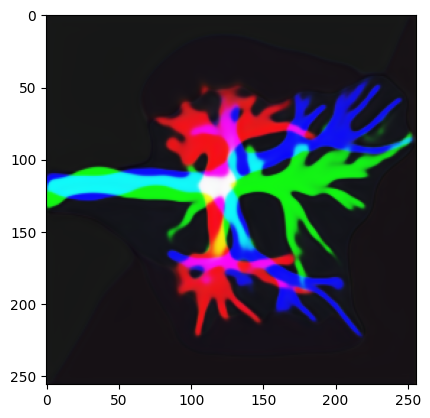

In [12]:
train_batch_8()

In [ ]:
train_batch_8()

Batch size:  8
Learning rate:  0.001
Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4
Average validation DICE score:  0.7135818533847729
Batch size:  8
Learning rate:  0.0001
Fold index:  0


KeyboardInterrupt: 

In [ ]:
train_batch_8()

Batch size:  8
Learning rate:  0.01
Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4
Average validation DICE score:  0.6921873145426313
Batch size:  8
Learning rate:  0.001
Fold index:  0


## Train the Best Model - batch size 8 and LR of 0.0001

Fold index:  0
Fold index:  1
Fold index:  2
Fold index:  3
Fold index:  4


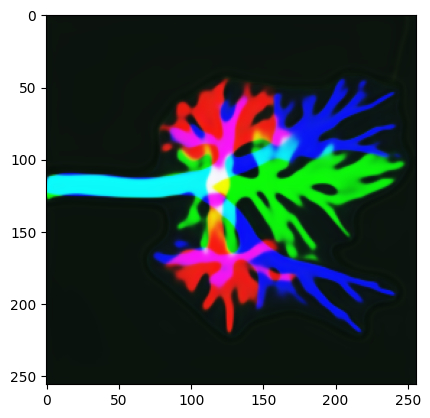

In [11]:
import os
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import numpy as np

learning_rate = 0.0001
batch_size = 8

def combined_loss(input, target):
    bce = nn.BCELoss()(input, target)
    dice = dice_loss(input, target)
    return (bce + dice) / 2

# Dice loss method
def dice_loss(input, target, smooth=1e-6):
    input = input.contiguous().view(input.shape[0], -1)
    target = target.contiguous().view(target.shape[0], -1)

    intersection = (input * target).sum(dim=1)
    dice = (2. * intersection + smooth) / (input.sum(dim=1) + target.sum(dim=1) + smooth)

    return 1 - dice.mean()

# Instantiate your dataset
dataset = NiftiDataset("mipsdata")

# Define the number of folds for cross-validation
num_folds = 5

# Initialize the KFold splitter
kf = KFold(n_splits=num_folds, shuffle=True)

best_model = None

# Iterate over each fold
fold_val_dice_scores = []
best_val_dice = 0
for fold_idx, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    print("Fold index: ", fold_idx)
    # Create data loaders for training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(train_index))
    val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(val_index))

    # Initialize model and optimizer
    model = AttentionUNet(img_ch=3, output_ch=3)
    model = model.to(device)
    criterion = combined_loss

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)

    # Training loop
    num_epochs = 40
    best_val_loss = float('inf')
    epoch_val_dice_scores = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        dice_score = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            plt.imshow(output[0].cpu().detach().numpy())
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + batch_idx / len(train_loader))

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_dice_score = 0.0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                # Compute Dice score
                output_binary = (output > 0.5).float()
                intersection = (output_binary * target).sum(dim=(1, 2, 3))
                dice = (2. * intersection + 1e-6) / (output_binary.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) + 1e-6)
                val_dice_score += dice.mean().item()

        avg_val_dice_score = val_dice_score / len(val_loader)
        epoch_val_dice_scores.append(avg_val_dice_score)

    # Check if current validation Dice score is best so far
    avg_epoch_val_dice_scores = np.mean(epoch_val_dice_scores)
    if avg_epoch_val_dice_scores > best_val_dice:
        best_val_dice = avg_epoch_val_dice_scores
        best_model_path = f'best_model.pth'
        torch.save(model.state_dict(), best_model_path)
        best_model = model

## Model Metrics

In [12]:
def tree_length(pred, true): 
    """
    Calculate the tree length based on the intersection of predicted and true binary arrays.

    Parameters:
        pred (np.array): Predicted binary array.
        true (np.array): True binary array.

    Returns:
        float: Length of the skeletonized predicted array within the true skeleton.

    """
    # Display true image for visualization
    plt.imshow(true)

    # Skeletonize the predicted and true binary arrays
    pred_skel = skeletonize(pred)
    true_skel = skeletonize(true)

    # Calculate the length of the skeletonized predicted array within the true skeleton
    return ((pred) * (true_skel)).sum() / (true_skel.sum())


def centerline_leakage(pred, true): 
    """
    Calculate the centerline leakage based on the difference between predicted and true skeletons.

    Parameters:
        pred (np.array): Predicted binary array.
        true (np.array): True binary array.

    Returns:
        float: Centerline leakage ratio.

    """
    # Skeletonize the predicted and true binary arrays
    pred_skel = skeletonize(pred)
    true_skel = skeletonize(true)
    
    # Calculate the outside pixels of the predicted skeleton that are not part of the true skeleton
    outside = np.sum(pred_skel - pred_skel * true)
    
    # Calculate the centerline leakage ratio
    return outside / np.sum(true_skel)


def fpr(pred, true): 
    """
    Calculate the false positive rate (FPR).

    Parameters:
        pred (np.array): Predicted binary array.
        true (np.array): True binary array.

    Returns:
        float: False positive rate.

    """
    # Calculate the number of false positive pixels
    fp = np.sum(pred - pred * true) 
    
    # Calculate the false positive rate
    fpr = fp / np.sum((1.0 - true))
    return fpr


def dice_score_coeff(pred, true):
    """
    Calculate the Dice coefficient for binary segmentation evaluation.

    Parameters:
        pred (np.array): Predicted binary array.
        true (np.array): True binary array.

    Returns:
        float: Dice coefficient.

    """
    # Calculate the intersection between predicted and true arrays
    intersection = (pred * true).sum()
    
    # Calculate the Dice coefficient
    dice = (2. * intersection) / (pred.sum() + true.sum())
    return dice.mean()


## Test Loop 

Average Tree Length: 0.7543562684957169
Average Centerline Leakage: 0.11353194571043052
Average False Positive Rate (FPR): 0.032340910363321505
Average Dice Score Coefficient: 0.801753768263504


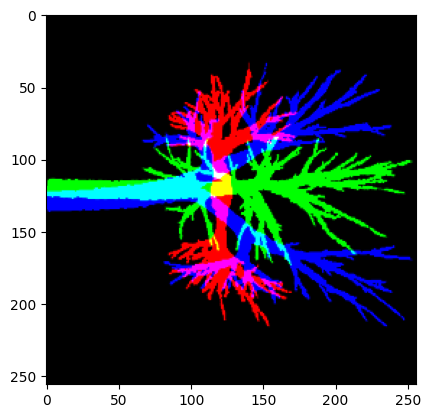

In [13]:
# Load test dataset using a DataLoader with batch size 8 and shuffle enabled
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Initialize variables to store cumulative metric values
total_tree_length = 0.0
total_centerline_leakage = 0.0
total_fpr = 0.0
total_dice_score = 0.0

# Get the total number of samples in the test dataset
num_samples = len(test_dataset)

# Disable gradient computation for inference
with torch.no_grad():
    # Iterate over batches in the test dataset
    for data, target in test_loader:
        # Move data and target tensors to the appropriate device (e.g., GPU)
        data, target = data.to(device), target.to(device)
        
        # Forward pass through the model to get predictions
        output = best_model(data)
        
        # Convert target tensor to numpy array for evaluation metrics
        target = target.cpu().numpy()
        
        # Convert model output to binary array and move it to CPU for evaluation metrics
        output_binary = (output > 0.5).float().cpu().numpy()
    
        # Calculate metrics for each sample in the current batch
        for i in range(len(output_binary)):
            total_tree_length += tree_length(output_binary[i], target[i])
            total_centerline_leakage += centerline_leakage(output_binary[i], target[i])
            total_fpr += fpr(output_binary[i], target[i])
            total_dice_score += dice_score_coeff(output_binary[i], target[i])

# Calculate average metric values over all samples
avg_tree_length = total_tree_length / num_samples
avg_centerline_leakage = total_centerline_leakage / num_samples
avg_fpr = total_fpr / num_samples
avg_dice_score = total_dice_score / num_samples

# Print average metric values
print(f"Average Tree Length: {avg_tree_length}")
print(f"Average Centerline Leakage: {avg_centerline_leakage}")
print(f"Average False Positive Rate (FPR): {avg_fpr}")
print(f"Average Dice Score Coefficient: {avg_dice_score}")
